In [1]:
%matplotlib inline

In [2]:
%config InlineBackend.figure_format = "retina"

In [3]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

# Disable annoying font warnings
matplotlib.font_manager._log.setLevel(50)

# Disable theano deprecation warnings
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning, module='theano')

# Style
plt.style.use('default')
plt.rcParams['savefig.dpi'] = 100
plt.rcParams['figure.dpi'] = 100
plt.rcParams['figure.figsize'] = (12, 4)
plt.rcParams['font.size'] = 14
plt.rcParams['text.usetex'] = False
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Liberation Sans']
plt.rcParams['font.cursive'] = ['Liberation Sans']
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['mathtext.fallback_to_cm'] = True

In [4]:
from starry_process import StarryProcess
from starry_process.inclination import InclinationIntegral
from starry_process.math import matrix_sqrt
import theano
import theano.tensor as tt
from theano.ifelse import ifelse
from tqdm.notebook import tqdm
import starry
from scipy.special import gamma, hyp2f1
from starry_process.ops import rTA1Op, tensordotRzOp, RxOp
from starry_process.wigner import R

In [5]:
sp = StarryProcess(contrast=[1.0 / np.pi, 1.0])
mu = sp.mean_ylm.eval()
cho_cov = sp.cho_cov_ylm.eval()
map = starry.Map(15, lazy=False)
e0 = sp.longitude.first_moment()
eigE0 = sp.longitude.second_moment()

Pre-computing some matrices... Done.


In [6]:
def get_cov_num(t, nsamples=10000):
    f = np.zeros((nsamples, len(t)))
    y = mu[:, None] + np.dot(cho_cov, np.random.randn(256, nsamples))
    inc = np.arccos(np.random.random(nsamples)) * 180 / np.pi
    for k in tqdm(range(nsamples)):
        map.inc = inc[k]
        A = map.design_matrix(theta=360 * t)
        f[k] = np.transpose(A @ y[:, k])
    return np.cov(f.T)[0]

In [7]:
class Inclination:
    def __init__(self, ydeg, mom1, eigmom2, period=1.0, **kwargs):
        self._ydeg = ydeg
        self._nylm = (self._ydeg + 1) ** 2
        self._period = tt.as_tensor_variable(period)

        # Set up the ops
        self._rTA1 = rTA1Op(self._ydeg, **kwargs)().eval()
        self._tensordotRz = tensordotRzOp(ydeg, **kwargs)
        self._Rx = RxOp(ydeg, **kwargs)
        self._R = R(self._ydeg, cos_alpha=0, sin_alpha=1, cos_gamma=0, sin_gamma=-1)

        # Pre-compute the integrals
        self._precompute()

        # Get the moments of the Ylm process in the polar frame
        self._ez = tt.transpose(self._dotRx(tt.reshape(mom1, (1, -1)), 0.5 * np.pi))
        eigEz = tt.transpose(self._dotRx(tt.transpose(eigmom2), 0.5 * np.pi))
        self._Ez = tt.dot(eigEz, tt.transpose(eigEz))

    def _dotRx(self, M, theta):
        """
        Dot a matrix `M` into the Wigner x-hat rotation matrix, `Rx(theta)`.
        
        """
        f = tt.zeros_like(M)
        rx = self._Rx(theta)[0]
        nwig = lambda l: ((l + 1) * (2 * l + 1) * (2 * l + 3)) // 3
        for l in range(self._ydeg + 1):
            start = nwig(l - 1)
            stop = nwig(l)
            Rxl = tt.reshape(rx[start:stop], (2 * l + 1, 2 * l + 1))
            f = tt.set_subtensor(
                f[:, l ** 2 : (l + 1) ** 2], tt.dot(M[:, l ** 2 : (l + 1) ** 2], Rxl),
            )
        return f

    def _rotate(self, theta):
        """
        Rotate a moment matrix in phase.
        
        """
        return self._tensordotRz(self._Ez, tt.tile(theta, self._nylm))

    def _G(self, j, i):
        """
        This is the integral of
         
            cos(x / 2)^i sin(x / 2)^j sin(x)
        
        from 0 to pi/2.
        """
        return 2 * gamma(1 + 0.5 * i) * gamma(1 + 0.5 * j) / gamma(
            0.5 * (4 + i + j)
        ) - (2 ** (1 - 0.5 * i) / (2 + i)) * hyp2f1(
            1 + 0.5 * i, -0.5 * j, 2 + 0.5 * i, 0.5
        )

    def _precompute(self):
        """
        Pre-compute the marginalization integrals.
        
        """
        print("Pre-computing the inclination integral...")
        G = np.array(
            [
                [self._G(i, j) for i in range(4 * self._ydeg + 1)]
                for j in range(4 * self._ydeg + 1)
            ]
        )

        # First moment integral
        self._t = [None for l in range(self._ydeg + 1)]
        for l in range(self._ydeg + 1):
            m = np.arange(-l, l + 1)
            i = slice(l ** 2, (l + 1) ** 2)
            self._t[l] = self._rTA1[i] @ self._R[l] @ G[l - m, l + m]

        # Second moment integral
        self._T = np.zeros((self._nylm, self._nylm))
        for i in tqdm(range(self._nylm)):
            l1 = int(np.floor(np.sqrt(i)))
            k = np.arange(l1 ** 2, (l1 + 1) ** 2)
            k0 = np.arange(2 * l1 + 1).reshape(-1, 1)
            for p in range(self._nylm):
                l2 = int(np.floor(np.sqrt(p)))
                j = np.arange(l2 ** 2, (l2 + 1) ** 2)
                j0 = np.arange(2 * l2 + 1).reshape(1, -1)
                Wik = self._rTA1[i] * self._R[l1][i - l1 ** 2, k - l1 ** 2]
                Wjp = self._rTA1[j] @ self._R[l2][j - l2 ** 2, p - l2 ** 2]
                M = G[k0 + j0, 2 * l1 - k0 + 2 * l2 - j0]
                self._T[k, p] += Wik @ M @ Wjp
        print("Done.")

    def first_moment(self):
        return tt.sum(
            [
                tt.dot(self._t[l], self._ez[slice(l ** 2, (l + 1) ** 2)])
                for l in range(self._ydeg + 1)
            ]
        )

    def second_moment(self, t):
        theta = 2 * np.pi / self._period * t
        E = tt.transpose(
            theano.scan(fn=self._rotate, outputs_info=None, sequences=[theta],)[0]
        )
        return tt.tensordot(self._T, E)
    
    
I = Inclination(15, e0, eigE0)
_t = tt.dvector()
get_cov = theano.function([_t], I.second_moment(_t) - I.first_moment() ** 2)

Pre-computing the inclination integral...



Done.


In [8]:
t = np.linspace(0, 1, 1000)
cov = get_cov(t)

In [9]:
cov_num = get_cov_num(t)

Compiling `X`... Done.


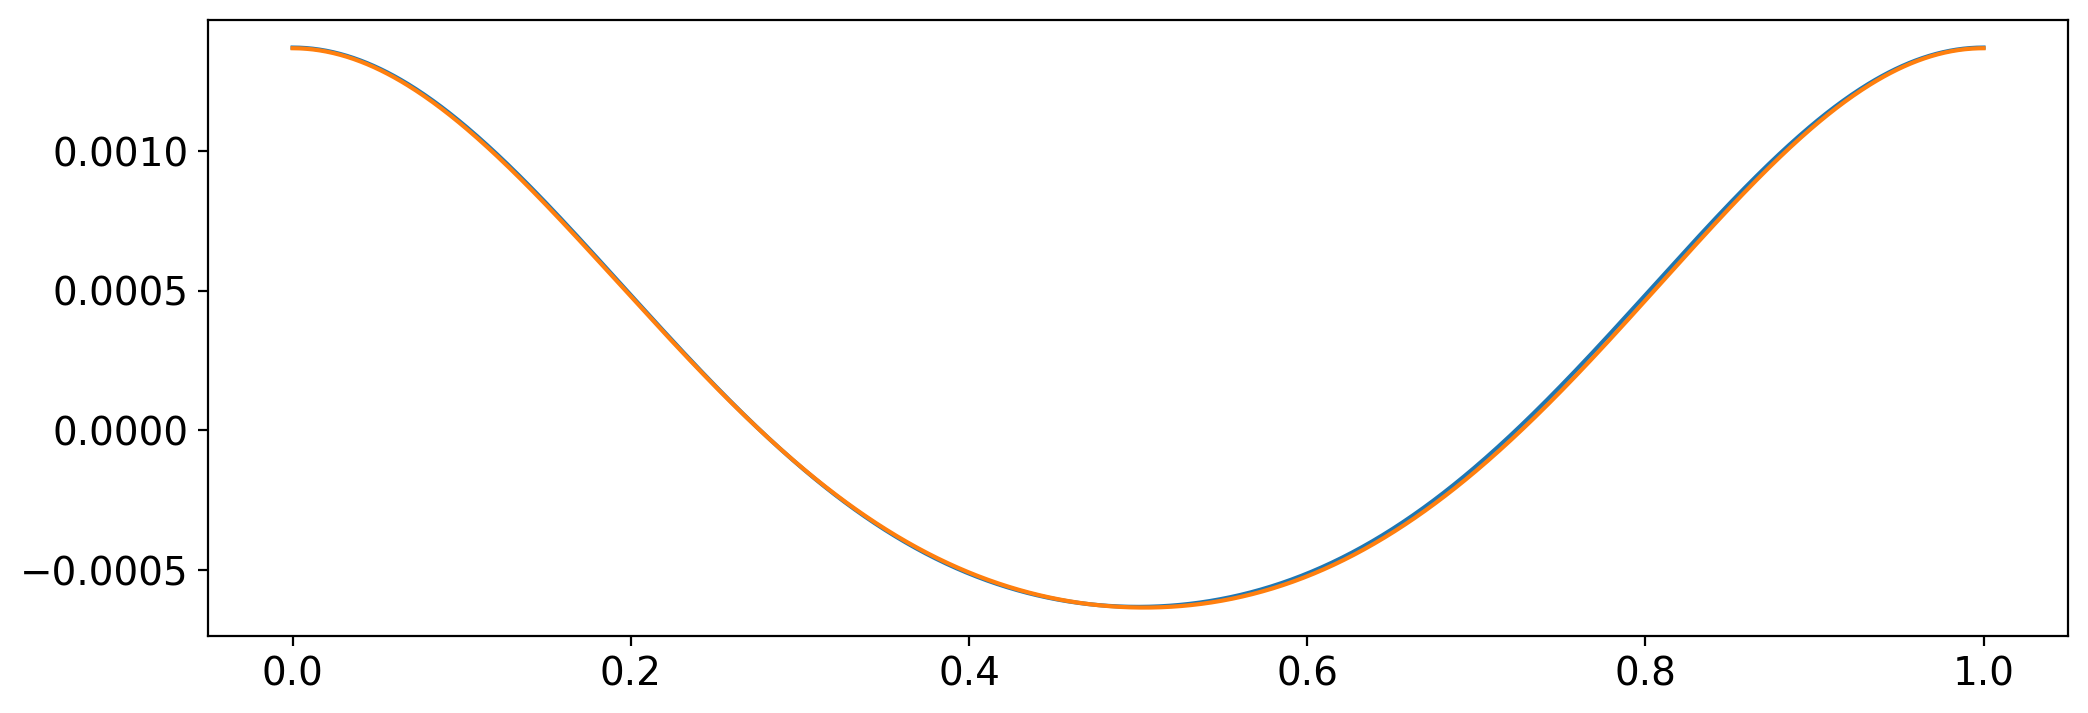

In [10]:
plt.plot(t, cov)
plt.plot(t, cov_num)